## dataset properties & LLM tokenization of dataset

* figure out distribution of token differences across sentence pairs for each tokenizer
* figure out distribution of tokens per target word for each tokenizer
* figure out average number of same- v. different-sense comparisons

In [1]:
%reset
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

import os 
import torch
import transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from transformers import AutoTokenizer

sns.set(style="whitegrid",font_scale=1.2)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
### Load the dataset

stimpath = "../data/raw/items/"
df = pd.read_csv(os.path.join(stimpath,"sawc_sentence_pairs.csv"))



### total number of sentence pairs

In [4]:
### Get total number of sentence pairs

print("total # sentence pairs: ", df.shape[0]) 

total # sentence pairs:  812


### average number of same-sense and different-sense pairs per target noun

In [7]:
df.groupby("Word").sum()["Same_sense"].mean()

2.3627450980392157

In [22]:
gdf = df.groupby("Word").sum()["Same_sense"].reset_index()
gdf["Total_pairs"] = df.groupby("Word").count()["Same_sense"].reset_index()["Same_sense"]
gdf["Different_sense"] = gdf["Total_pairs"] - gdf["Same_sense"] 

print("mean number of same-sense pairs per noun: ", gdf["Same_sense"].mean())
print("mean number of different-sense pairs per noun: ", gdf["Different_sense"].mean())
print("mean number of sentence pairs per noun: ", gdf["Total_pairs"].mean())

mean number of same-sense pairs per noun:  2.3627450980392157
mean number of different-sense pairs per noun:  5.598039215686274
mean number of sentence pairs per noun:  7.96078431372549


Text(0.5, 0, '# different-sense sentence pairs')

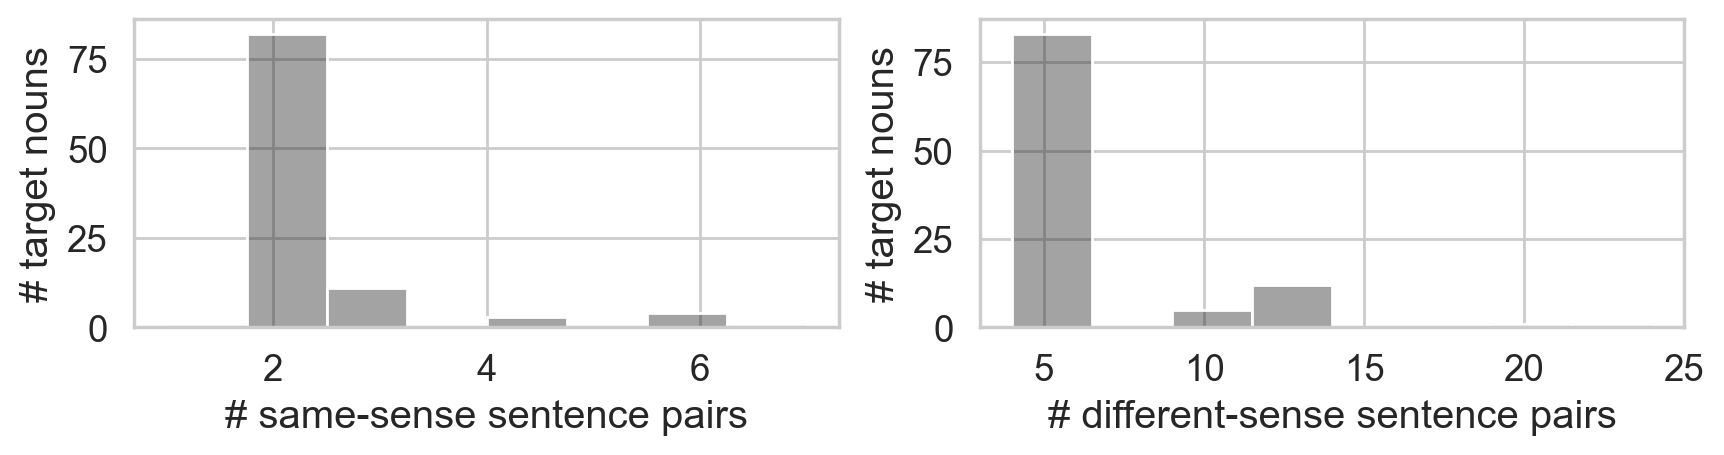

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,2))

sns.histplot(data=gdf,
             x="Same_sense",
             color="k",
             alpha=0.4,
             ax=ax[0]
            ).set_ylabel("# target nouns")
ax[0].set_xlabel("# same-sense sentence pairs")


sns.histplot(data=gdf,
             x="Different_sense",
             color="k",
             alpha=0.4,
             ax=ax[1]
            ).set_ylabel("# target nouns")
ax[1].set_xlabel("# different-sense sentence pairs")

### number of target nouns with grammatical gender switch across senses


In [21]:
### Count the number of words for which the sense changes with the grammatical gender

words = list(set(df["Word"].tolist()))

switch = 0
gather = []
for word in words:
    
    subword = df[df["Word"]==word]
    
    genders = subword["Same_gender"].tolist()
    if False in genders: 
        switch += 1
        gather.append(word)
        
print(switch)
print(gather)

9
['naranja', 'corte', 'cura', 'capital', 'papa', 'pieza', 'guardia', 'rosa', 'frente']


One of these (`pieza`) is only in this list because of a typo in the word `female` (`femael`) in the `Gender` column!! The rest really do have different grammatical genders as a function of sense. 


### tokenization differences across sentence pairs, across model tokenizers

In [31]:
### Define the url paths to download your desired models
#.  from Hugging Face

MODELS = ["dccuchile/bert-base-spanish-wwm-cased",
          "google-bert/bert-base-multilingual-cased",
          "FacebookAI/xlm-roberta-base",
          "dccuchile/albert-tiny-spanish",
          "dccuchile/albert-base-spanish",
          "dccuchile/albert-large-spanish",
          "dccuchile/albert-xlarge-spanish",
          "dccuchile/albert-xxlarge-spanish",
          "PlanTL-GOB-ES/roberta-base-bne",
          "PlanTL-GOB-ES/roberta-large-bne",
          "dccuchile/bert-base-spanish-wwm-uncased", 
          "dccuchile/distilbert-base-spanish-uncased"]

### Iterate over models and get token counts: 
#   per sentences -- and get token differences
#   per target words

gather = []
for mpath in tqdm(MODELS,colour="cornflowerblue"):

    ### Grab your model's identifier
    model_name = mpath.split("/")[1]
    
    ### Decide which device you want the models to run in
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    ### Load your model & tokenizer
    model = transformers.AutoModel.from_pretrained(mpath,output_hidden_states=True)
    model.to(device) # allocate model to desired device
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)  
    
    for (ix, row) in tqdm(df.iterrows(), total=df.shape[0]):

        ### Get sentences for S1 and S2

        # note: account for tokenization differences in RoBERTa Spanish monolinguals  by
        #.      adding a whitespace in front of the target word (otherwise, the function
        #.      `find_sublist_index` will not be able to identify the target token-s within
        #.      the tokenized sentence)

        if mpath in ["PlanTL-GOB-ES/roberta-base-bne", "PlanTL-GOB-ES/roberta-large-bne"]:
            target = " {w}".format(w = row['Word'])
        else:
            target = row['Word']
            
        
        ### Figure out how many tokens you're
        ### comparing across sentences
        n_tokens_s1 = len(tokenizer.encode(row['Sentence_1']))
        n_tokens_s2 = len(tokenizer.encode(row['Sentence_2']))

        # Tokenize target
        target_tok = tokenizer.encode(target,
                                      add_special_tokens=False)
        
        
        d = {"Word": [target],
             "Model": [model_name],
             "Target_tokens": [target_tok],
             "Num_tokens_s1": [n_tokens_s1],
             "Num_tokens_s2": [n_tokens_s2]  
            }
        
        
        gather.append(pd.DataFrame(d))
        
        
token_properties = pd.concat(gather)
    

  0%|          | 0/12 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

In [34]:
token_properties["Num_token_diffs"] = token_properties["Num_tokens_s1"] - token_properties["Num_tokens_s2"]

In [37]:
token_properties.groupby(["Word","Model"]).mean()["Num_token_diffs"]

Word      Model                          
 aceite   roberta-base-bne                   0.000000
          roberta-large-bne                  0.000000
 ala      roberta-base-bne                  -0.500000
          roberta-large-bne                 -0.500000
 algodón  roberta-base-bne                  -0.666667
                                               ...   
órgano    bert-base-multilingual-cased       0.833333
          bert-base-spanish-wwm-cased        0.166667
          bert-base-spanish-wwm-uncased      0.666667
          distilbert-base-spanish-uncased    0.666667
          xlm-roberta-base                   1.500000
Name: Num_token_diffs, Length: 1224, dtype: float64

In [ ]:
sns.histplot(data=token_properties,
             x="Num_token_diffs",
             hue="Model",
             alpha=0.4
            ).set_ylabel("# target nouns")

In [33]:
token_properties.to_csv("token_properties.csv")

#### example sentences for paper: 

In [65]:
stimlist = pd.read_csv(os.path.join(stimpath, "sawc_stimlist.csv"))

In [67]:
stimlist[stimlist["Word"] == "aceite"]["Sentence"].tolist()

['Compró el aceite de oliva',
 'Compró el aceite de cocina',
 'Compró el aceite de motor',
 'Compró el aceite de carro']